In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import random
import heapq

In [2]:
# Read data and transform to a dataframe
X, y = load_svmlight_file('/content/diabetes_scale',n_features=8, dtype = np.float32)
y = pd.DataFrame(y)
X = pd.DataFrame(X.toarray())
X.rename({0:'Pregnancies',1:'Glucose',2:'BloodPressure',3:'SkinThickness',4:'Insulin',5:'BMI',6:'DiabetesPedigreeFunction',7:'Age'},axis = 1, inplace = True)
data = X.copy()
data['Outcome'] = y

In [3]:
# Dimension of data
print('Number of rows:',data.shape[0])
print('Number of columns:', data.shape[1])

Number of rows: 768
Number of columns: 9


In [4]:
# Checking NA in data
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

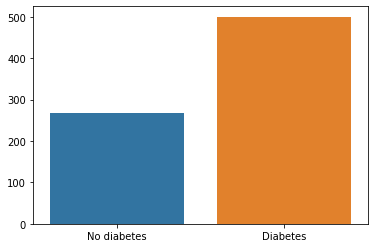

In [5]:
# We can check the Outcome variable
patient_outcome = data['Outcome'].value_counts()
ax = sns.barplot(x = patient_outcome.index,y = patient_outcome.values);
ax.set_xticklabels(['No diabetes', 'Diabetes']);

In [6]:
patient_outcome

 1.0    500
-1.0    268
Name: Outcome, dtype: int64

We can see that there are more cases with **diabetes** than **no diabetes**. Overall, it is easier to get better results for a class with more samples.

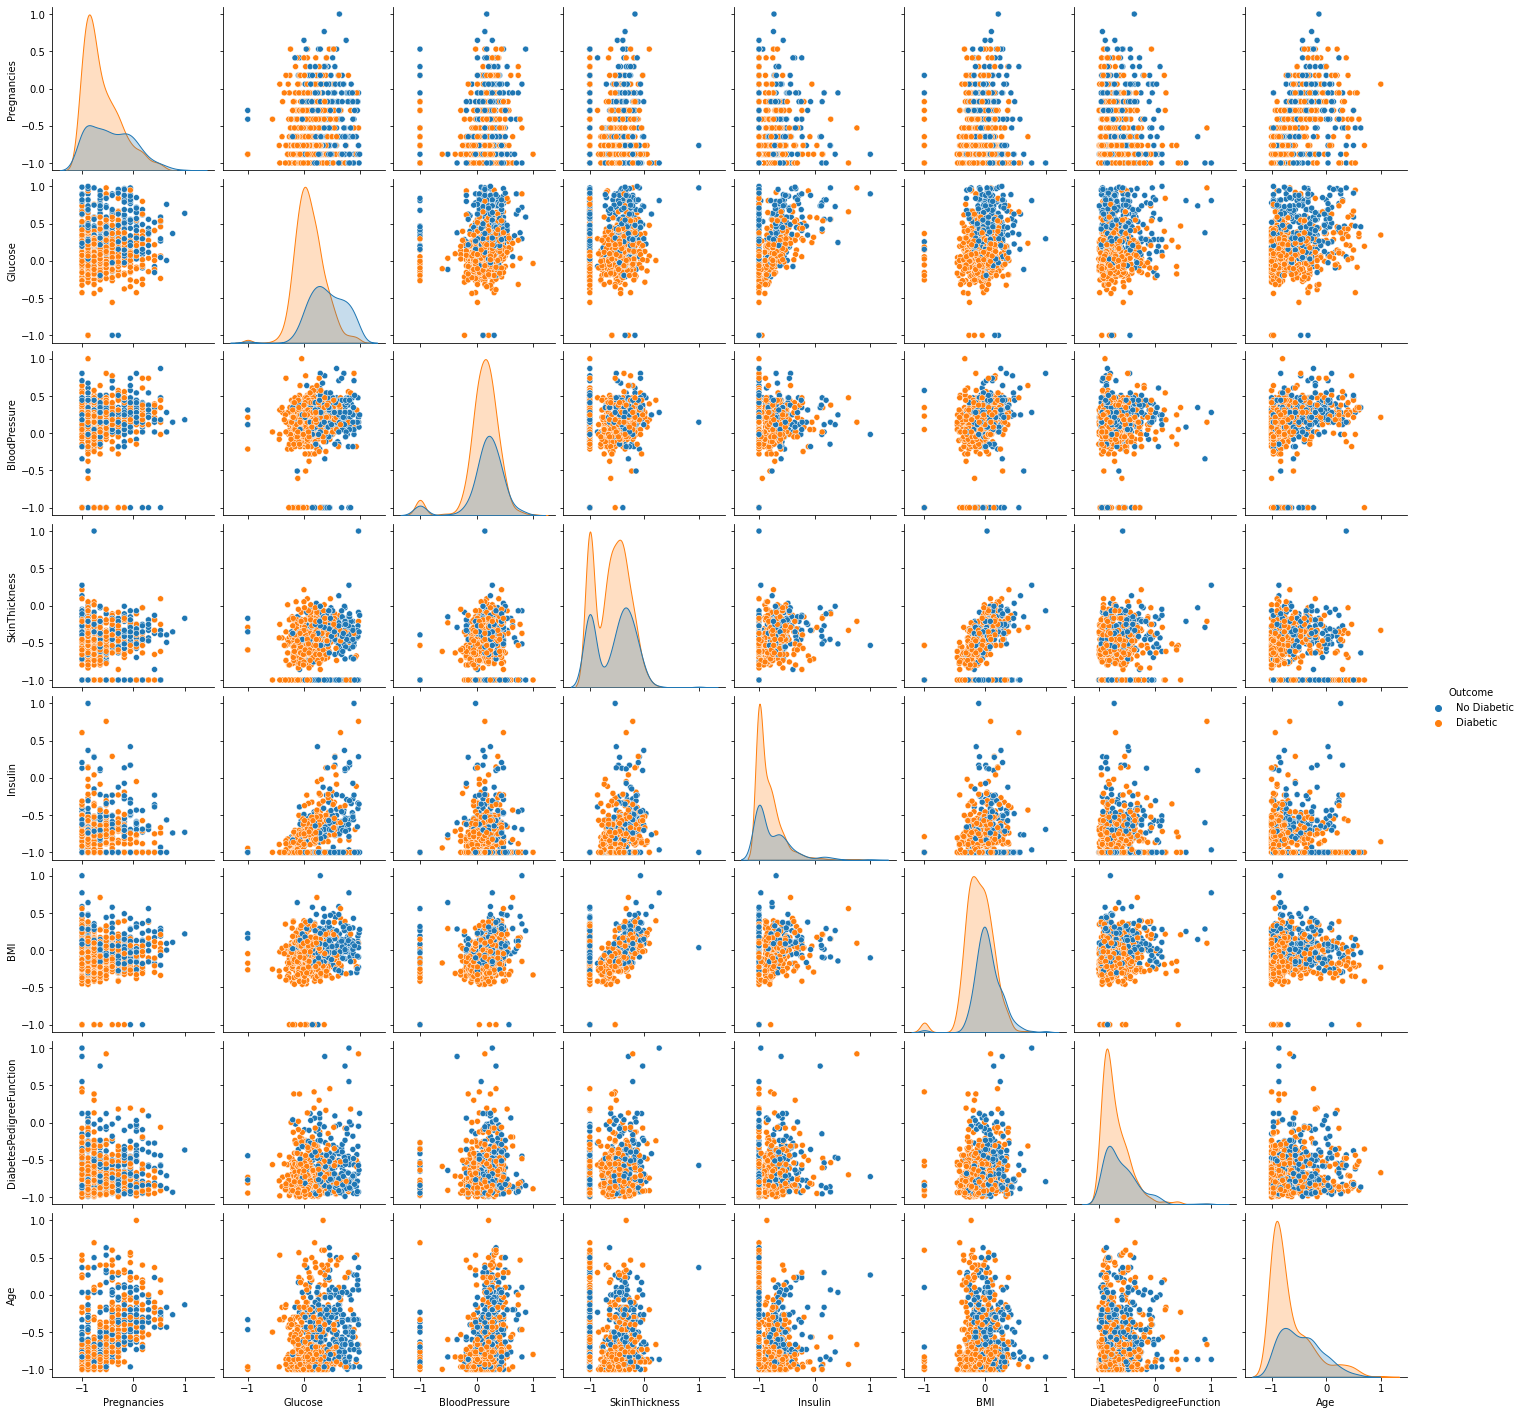

In [7]:
# We can see also how variables are related themselves
data_class = data.copy()
data_class['Outcome'] = np.where(data_class['Outcome'] == 1, 'Diabetic','No Diabetic')
sns.pairplot(data_class,hue = 'Outcome');

Checking the previous graph. we can see that values are correclty normalized showing values between -1 and 1 and they have different kind of distributions (symmetric, bimodal and rigth-left skewed).

Furthermore, visually is possible to check there are not clear outliers in data.

# **Preparing data**

In [8]:
# We go to split features descriptors from target
X = data.drop('Outcome' , axis = 1).values # Independent Feature
y = data['Outcome'].values # Target
# Fit values to -1 and 1
y = np.where(y == 1, 1,-1)

In [9]:
# Split data in train and test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.3,stratify=y,random_state=123)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=123) 

# **Creation of a Perceptron class**

In [10]:
# We create a class called perceptron
class perceptron():
  '''
  This class allows you create a perceptron model (zero hidden layer) neural 
  network. Some parameters could be modified to get a best fit
  '''
  # Initializate variables
  def __init__(self):    
    self.w = 0
    self.accuracy_training = []
    self.accuracy_validation = []
    self.parameters_history = []
    
  # We go to initialize weight and bias values as random
  def initialize_parameters(self,dim,include_bias = 'no'):
    '''
    This function allows to initialize parameters during the first iteration
    Arguments of this function:
    dim:              Number of features used to fit a model
    include_bias:     Default is 'no'. It allows to consider the bias parameters (intercept) ('yes') or not ('no').

    output: array of parameters w (1, number of features)
    '''
    if include_bias == 'yes':
      w = np.random.rand(1,dim + 1) # add 1 more value which corresponds to bias
      return w
    else:
      w = np.random.rand(1,dim) # Ignoring bias
      return w

  # As we need to multiply weights and bias, we need to add one column
  def add_col_bias(self,X):
    '''
    This function is used at moment when it is necessary to add bias term.
    For this, to the X array a new column with 1 values is added at the beginning.
    Arguments of this function:
    X:       array of samples and features
    
    output: array with a new column filled with 1.
    '''
    col_bias = np.ones((X.shape[0],1))
    return np.append(col_bias,X, axis=1) 

  # Do the prediction
  def prediction(self,X,include_bias = 'no'):
    '''
    This function is useful to do a prediction/estimation of our target using
    X array and weights values.
    Arguments of this function:
    X:               array of samples and features
    include_bias:    default is 'no'. It allows to consider the bias parameters (intercept) ('yes') or not ('no').  

    output:  estimation of target y         
    '''
    # In the case we are considering bias, we need to include a column
    if include_bias == 'yes':
      X = self.add_col_bias(X)
    # We create a list to save predictions
    pred = []
    output = []
    # Prediction for each sample
    for i in range(X.shape[0]):
      pred.append(float(np.dot(X[i,:],self.w.T)))
      if pred[i] < 0:
        output.append(-1)
      else:
        output.append(1)
    # Return output
    return output

  # Updating parameters
  def update_parameters(self,X,y,lr,include_bias = 'no',loss_function_update = 'zero-one'):
    '''
    This function is created to update parameters w in each iteration. For this, 
    we need to consider a certain learning rate and a loss function. 
    Arguments of this function:
    X:                         array of samples and features
    y:                         target
    lr:                        an integer or float value indicating the learning rate. 
    include_bias:              default is 'no'. It allows to consider the bias parameters (intercept) ('yes') or not ('no').  
    loss_function_update:      specifying the loss function that it will be used. 'zero-one', 'hinge' and 'perceptron' 
                               loss functions are the possible options. Default value is 'zero-one'. 
    
    output: an array with the new values of w. 
    '''
    if include_bias == 'yes':
      X = self.add_col_bias(X)
    result = []
    summation = 0
    for i in range(X.shape[0]):
      result.append(float(np.dot(X[i,:],self.w.T)))  # <x,w>
      result[i] = result[i]*y[i]  # <x,w>*y
      # zero-one loss function 
      if loss_function_update == 'zero-one':
        if result[i] < 0:
          result[i] = 1
        else:
          result[i] = 0
      # Perceptron loss function 
      elif loss_function_update == 'perceptron':
        result[i] = max(0,-result[i])
      # Hinge loss function
      elif loss_function_update == 'hinge':
        result[i] = max(0,1-result[i])
      # Updating weights
      summation += y[i]*X[i]*result[i]
    new_w = self.w+lr*summation
    return new_w

  # Getting accuracy
  def accuracy(self,y,prediction):
    '''
    Function to get accuracy, which is the ratio of correct prediction vs total of samples.
    Arguments of this function:
    y:              target
    prediction:     prediction of target using a fit model (trained)
    
    output:  accuracy value.
    '''
    right_pred = 0
    for i in range(y.shape[0]):
      if y[i] == prediction[i]:
        right_pred += 1
    return right_pred/y.shape[0]

  # Create a model which is fitted to data
  def fit(self,X,y,X_val = 'not_given',y_val = 'not_given',include_bias = 'no',lr = 0.001,epochs = 30,loss_function = 'zero-one'):
    '''
    Function to train perceptron model. 
    Arguments of this function:
    X:                         array of samples and features
    y:                         target
    x_val:                     array of samples and features (validation set)       
    y_val:                     target (validation set)
    include_bias:              default is 'no'. It allows to consider the bias parameters (intercept) ('yes') or not ('no').
    lr:                        an integer or float value indicating the learning rate. 
    epochs:                    Number of iterations to train a model
    loss_function_update:      specifying the loss function that it will be used. 'zero-one', 'hinge' and 'perceptron' 
                               loss functions are the possible options. Default value is 'zero-one'. 

    output:  updating w values            
    '''
    self.accuracy_training = []
    self.accuracy_val = []
    self.parameters_history = []
    for epoch in range(epochs):
      # In first iteration, we need to set certain values of weights
      if epoch == 0:
        self.w = self.initialize_parameters(X.shape[1],include_bias)
        # Save parameters w in an array of historic parameters
        self.parameters_history = np.array(self.w)
      # Perform prediction of y in training and validation set
      self.accuracy_training.append(self.accuracy(y,self.prediction(X,include_bias)))
      if type(X_val) != str and type(y_val) != str:
        self.accuracy_val.append(self.accuracy(y_val,self.prediction(X_val,include_bias)))
      # Getting loss function and update parameters
      self.w = self.update_parameters(X,y,lr,include_bias,loss_function_update = loss_function)
      # Save new parameters in parameters_history
      self.parameters_history = np.concatenate((self.parameters_history, self.w), axis=0)
    # We go to save the accuracy in last updating
    self.accuracy_training.append(self.accuracy(y,self.prediction(X,include_bias)))
    if type(X_val) != str and type(y_val) != str:
     self.accuracy_val.append(self.accuracy(y_val,self.prediction(X_val,include_bias)))
    return 'Model has been trained successfully!'

  # Create a function to plot accuracy values of training (and validation)
  def plot_accuracy(self,pass_to_object = False):
    '''
    Plotting accuracy values through each epoch

    output: Plot with accuracy values.
    '''
    plt.plot(self.accuracy_training, label = "Train accuracy", linestyle="-")
    plt.plot(self.accuracy_val, label = "Val accuracy", linestyle="--")
    plt.xlabel('Number of epoch')
    plt.ylabel('Accuracy')
    plt.title('Evolution of accuracy along epochs')
    plt.legend()
    plt.show()

  def plot_evolution_parameters(self):
    '''
    Plotting parameters w through each poch

    output: Plot with w parameters values.
    '''
    for i in range(self.parameters_history.shape[1]):
      plt.plot(self.parameters_history[:,i],label = 'w'+str(i+1))
    plt.xlabel('Number of epoch')
    plt.ylabel('Weights')
    plt.title('Evolution of parameters along epochs')
    plt.legend()
    plt.show()

# **Base case implementation**

In [11]:
# Set a seed to get same random values each time
random.seed(10)

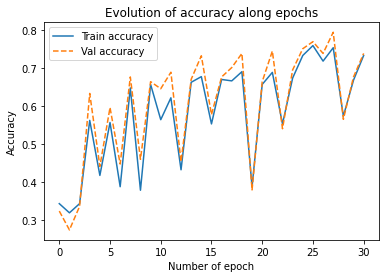

Accuracy in test data is:  0.7571428571428571


In [12]:
# Base case is using learning rate of 0.001, 30 epohs, non including bias and zero-one loss function.

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val)
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test)
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

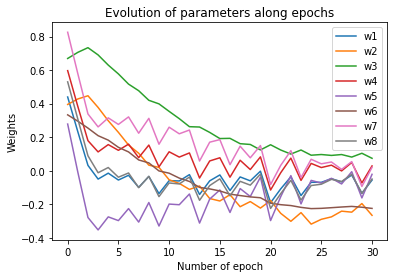

In [13]:
# Also, we can see how the value of parameters w goes to change through epochs.
Perceptron.plot_evolution_parameters()

# **Experiments**

## **1) Considering bias**

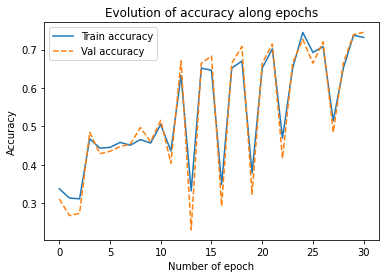

Accuracy in test data is:  0.7


In [14]:
# Using bias

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes')
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

## **2) Using Perceptron loss function**

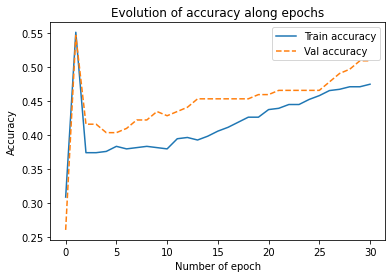

Accuracy in test data is:  0.4142857142857143


In [15]:
# Using 'perceptron' loss_function

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',loss_function='perceptron')
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

## **3) Using Hinge loss function**

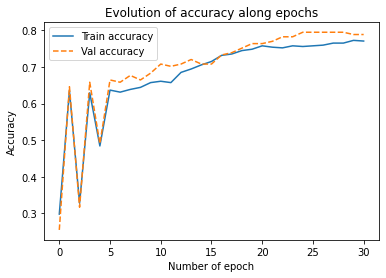

Accuracy in test data is:  0.7142857142857143


In [16]:
# Using 'hinge' loss_function

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',loss_function='hinge')
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

## **4) Using different learning rates**

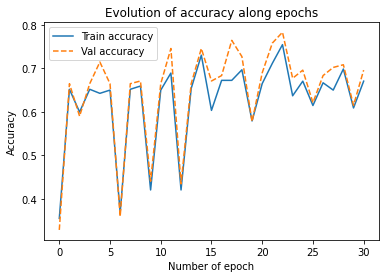

Accuracy in test data is:  0.6285714285714286


In [17]:
# Using lr = 0.1

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',lr = 0.1)
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

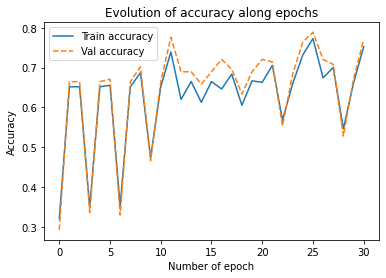

Accuracy in test data is:  0.7857142857142857


In [18]:
# Using lr = 0.01

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',lr = 0.01)
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

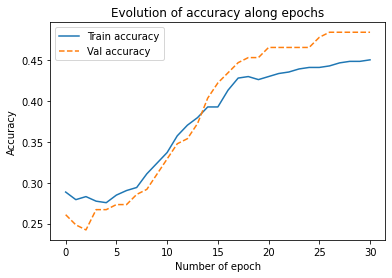

Accuracy in test data is:  0.45714285714285713


In [19]:
# Using lr = 0.0001

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',lr = 0.0001)
Perceptron.plot_accuracy()

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy in test data is: ', Perceptron.accuracy(y_test,y_pred))

# **Test using sklearn**

In [20]:
# Now, we go to use sklearn to implement a perceptron model

# Load packages
from sklearn.linear_model import Perceptron as Perceptron_sklearn
import warnings
warnings.filterwarnings('ignore') 

# Create model
perceptron_sklearn = Perceptron_sklearn(max_iter = 50,random_state=0)

# We can check what is the loss function that sklearn uses by default
print('Loss function used is: ',perceptron_sklearn.loss)
perceptron_sklearn.fit(X_train, y_train)

# Make a prediction
print('Accuracy in test data is: ',perceptron_sklearn.score(X_test,y_test))

Loss function used is:  perceptron
Accuracy in test data is:  0.7285714285714285


# **Comparing own model with sklearn**

In [21]:
# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',loss_function='perceptron',lr = 0.0001,epochs = 50)

# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# We can get the accuracy in test
print('Accuracy of own model in test data is: ', Perceptron.accuracy(y_test,y_pred))

Accuracy of own model in test data is:  0.38571428571428573


In [22]:
# Now, we can go to implement sklearn model
accuracy_train_sklearn = []  
accuracy_val_sklearn = []  
for epoch in range(1,51):
  # Create a sklearn object
  perceptron_sklearn = Perceptron_sklearn(max_iter = epoch,random_state=42,eta0 = 0.0001,alpha = 0)
  # Try to use the same weights and bias as our own model
  perceptron_sklearn.fit(X_train, y_train,coef_init = Perceptron.parameters_history[0,1:],intercept_init = Perceptron.parameters_history[0,0])
  # Getting accuracy for train data
  accuracy_train_sklearn.append(perceptron_sklearn.score(X_train,y_train))
  # Getting accuracy for validation data
  accuracy_val_sklearn.append(perceptron_sklearn.score(X_val,y_val))

# Make a prediction
print('Accuracy of sklearn model in test data is: ',perceptron_sklearn.score(X_test,y_test))

Accuracy of sklearn model in test data is:  0.6


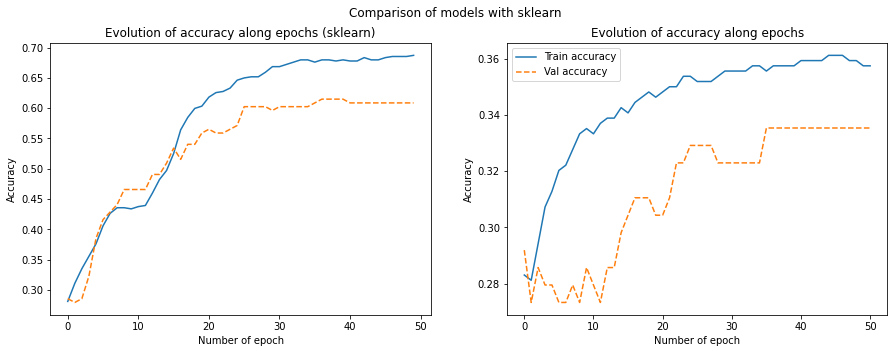

In [23]:
# Createa plot with results of sklearn and own model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparison of models with sklearn')
ax1.plot(accuracy_train_sklearn, label = "Train accuracy", linestyle="-")
ax1.plot(accuracy_val_sklearn, label = "Val accuracy", linestyle="--")
ax1.set_title('Evolution of accuracy along epochs (sklearn)')
ax1.set_xlabel('Number of epoch')
ax1.set_ylabel('Accuracy')
ax2 = Perceptron.plot_accuracy()

We can see that sklearn model performs better than our model, however we know that this could be due to sklearn has more parameters to set such as **alpha**, which is a constant that multiplies regularization term, l1_ratio, which is a kind of penalty and so on. However, using our own model and try different values of the main parameters, number of epochs, learning rate and loss function we can get a better performance. 

# **Grid Search**

Now. we go to use a combination of parameters to find which is the best fit for the given data. We go to create a manual grid search using loops and determine which are the best parameters using validation data

In [24]:
# Set hyperparameters
grid_epochs = [30,50,100,150]
grid_lr = [1,0.1,0.01,0.001]
grid_loss = ['perceptron','hinge','zero-one']

# Set an empty list to save accuracy values
accuracy_list = []
model_number = 1
for n_epoch in grid_epochs:
  for n_lr in grid_lr:
    for n_loss in grid_loss:
      # Create class
      Perceptron = perceptron()

      # We can create a basic model
      Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',lr =n_lr,epochs=n_epoch,loss_function=n_loss)

      # We can predict in test data
      y_pred = Perceptron.prediction(X_val,include_bias= 'yes')
      # Save accuracy values
      accuracy_list.append([n_epoch,n_lr,n_loss,Perceptron.accuracy(y_val,y_pred)])
      
      # We can get the accuracy in test
      print(f'Model N {model_number}. Accuracy in validation data with {n_epoch} epochs and {n_lr} learning rate and {n_loss} loss function : ', Perceptron.accuracy(y_val,y_pred))

      # Increase counter
      model_number += 1

Model N 1. Accuracy in validation data with 30 epochs and 1 learning rate and perceptron loss function :  0.33540372670807456
Model N 2. Accuracy in validation data with 30 epochs and 1 learning rate and hinge loss function :  0.33540372670807456
Model N 3. Accuracy in validation data with 30 epochs and 1 learning rate and zero-one loss function :  0.6832298136645962
Model N 4. Accuracy in validation data with 30 epochs and 0.1 learning rate and perceptron loss function :  0.33540372670807456
Model N 5. Accuracy in validation data with 30 epochs and 0.1 learning rate and hinge loss function :  0.33540372670807456
Model N 6. Accuracy in validation data with 30 epochs and 0.1 learning rate and zero-one loss function :  0.6956521739130435
Model N 7. Accuracy in validation data with 30 epochs and 0.01 learning rate and perceptron loss function :  0.33540372670807456
Model N 8. Accuracy in validation data with 30 epochs and 0.01 learning rate and hinge loss function :  0.33540372670807456
M

In [25]:
# Select the model with the k best fit
def best_k_models(list_accuracy_values,best_k = 5):
    max_index = [i for x, i in heapq.nlargest(best_k,((x, i) for i, x in enumerate([sublist[-1] for sublist in list_accuracy_values])))]
    for n_best in range(0,len(max_index)):
      print(f'The best {n_best+1} model has {list_accuracy_values[max_index[n_best]][0]} epochs, {list_accuracy_values[max_index[n_best]][1]} learning rate and {list_accuracy_values[max_index[n_best]][2]} loss function with {list_accuracy_values[max_index[n_best]][3]} accuracy in validation set')
    return list_accuracy_values[max_index[0]][0],list_accuracy_values[max_index[0]][1],list_accuracy_values[max_index[0]][2]

# Getting parameters for best performance and show the best 5 models
best_epoch, best_lr, best_loss = best_k_models(accuracy_list,best_k =5)

The best 1 model has 150 epochs, 0.001 learning rate and hinge loss function with 0.7701863354037267 accuracy in validation set
The best 2 model has 50 epochs, 0.001 learning rate and hinge loss function with 0.7701863354037267 accuracy in validation set
The best 3 model has 30 epochs, 0.001 learning rate and hinge loss function with 0.7701863354037267 accuracy in validation set
The best 4 model has 30 epochs, 0.01 learning rate and zero-one loss function with 0.7701863354037267 accuracy in validation set
The best 5 model has 100 epochs, 0.001 learning rate and hinge loss function with 0.7639751552795031 accuracy in validation set


In [26]:
# We can get finally the accuracy in test dataset

# Create class
Perceptron = perceptron()

# We can create a basic model
Perceptron.fit(X_train,y_train,X_val,y_val,include_bias = 'yes',lr =best_lr,epochs=best_epoch,loss_function=best_loss)
# We can predict in test data
y_pred = Perceptron.prediction(X_test,include_bias= 'yes')
# Save accuracy values
print('Accuracy of own model (best fit) in test data is: ', Perceptron.accuracy(y_test,y_pred))

Accuracy of own model (best fit) in test data is:  0.7571428571428571


Now we can plot the accuracy evolution for our best case.

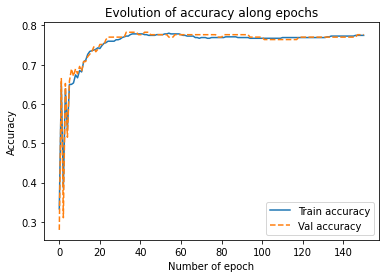

In [27]:
# Plotting best case
Perceptron.plot_accuracy()

# **Analysis of results**

We can evaluate also the performance of our model analysing which are the correct prediction and which are not. For this we can create a confusion matrix. 


In [28]:
# Frequency of classes in test data
unique, counts = np.unique(y_test, return_counts=True)
print('Frecuency of classes')
print(dict(zip(unique, counts)))

# Getting confusion matrix
print('Confusion matrix: ')
confusion_matrix(y_pred,y_test)

Frecuency of classes
{-1: 27, 1: 43}
Confusion matrix: 


array([[13,  3],
       [14, 40]])

Clearly, we can see that our main mistakes happen about **-1** class ('No diabetes'). This could be due to that class does not have much samples or simply because is hard to model. It is important to notice that perceptron algorithm is a basic machine learning model, which could be improved using a more complex model with multilayer neural networks. 